## Import statements

In [653]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Functions

### Function to analyze unisex names

In [654]:
def unisex_name_analysis(df):
    most_popular_unisex_name_men = df.aantal_man.sort_values(ascending=False).index[0]
    most_popular_unisex_name_women = df.aantal_vrouw.sort_values(ascending=False).index[0]
    most_popular_unisex_name = df.aantal_totaal.sort_values(ascending=False).index[0]

    print(f'Populairste unisex naam bij mannen: {most_popular_unisex_name_men}')
    print(f'Populairste unisex naam bij vrouwen: {most_popular_unisex_name_women}')
    print(f'Populairste unisex naam: {most_popular_unisex_name}')

### Function to detect outliers

In [655]:
def detect_outliers_with_rolling_window(data, window_size=7, threshold=2):
    """
    Detect outliers in a time series using a rolling window approach with quartiles and IQR.

    Parameters:
    - data: DataFrame with datetime index and a column containing the data to be analyzed.
    - window_size: Size of the rolling window in days (default is 7 days).
    - threshold: Multiplier for determining outlier bounds based on the rolling IQR (default is 2).

    Returns:
    - DataFrame containing outliers.
    """

    # Calculate quartiles and IQR using rolling window
    rolling = data.rolling(window=window_size)
    rolling_Q1 = rolling.quantile(0.25)
    rolling_Q3 = rolling.quantile(0.75)
    rolling_IQR = rolling_Q3 - rolling_Q1

    # Define outlier bounds using rolling IQR
    rolling_lower_bound = rolling_Q1 - threshold * rolling_IQR
    rolling_upper_bound = rolling_Q3 + threshold * rolling_IQR

    # Detect outliers
    outliers = data[(data < rolling_lower_bound) | (data > rolling_upper_bound)]

    return outliers

## Stap 1: data inlezen

In [656]:
loc_data = os.path.join('..', 'data', 'input', 'geboortes')

dfs = list()
for filename in os.listdir(loc_data):
    df = pd.read_csv(os.path.join(loc_data, filename))
    df['datum'] = filename.replace('.csv', '')
    dfs.append(df)
    
df_birth_raw = pd.concat(dfs, ignore_index = True)
df_birth = df_birth_raw.copy()

In [657]:
df_birth_raw.head()

,gemeente,naam,geslacht,verwachte datum,datum
0,Hooglede,Elias,Mannelijk,01/14/2019,2019-1-1
1,Sint-Niklaas (Sint-Niklaas),Pauline,Vrouwelijk,01/05/2019,2019-1-1
2,Wijnegem,Anita,Vrouwelijk,01/05/2019,2019-1-1
3,Grâce-Hollogne,Jean-Paul,Mannelijk,01/13/2019,2019-1-1
4,Boussu,François,Mannelijk,01/26/2019,2019-1-1


### Transform datum column into datetime objects and separate invalid dates

In [658]:
# Create a copy of the original DataFrame to preserve the original date strings
df_wrong = df_birth.copy()

# Convert 'datum' column to datetime with error handling
df_birth['datum'] = pd.to_datetime(df_birth['datum'], errors='coerce')

# Filter out rows with invalid dates
valid_dates_mask = df_birth['datum'].notna()
df_wrong = df_wrong[~valid_dates_mask]
df_birth = df_birth[valid_dates_mask]

# Rename column datum of df_wrong as reason
df_wrong.rename(columns={'datum': 'reason'}, inplace=True)

In [659]:
df_wrong.head()

,gemeente,naam,geslacht,verwachte datum,reason
44768,Kruisem,Patrick,Mannelijk,02/27/2019,2019-2-29
44769,Montigny-le-Tilleul,Sarah,Vrouwelijk,03/11/2019,2019-2-29
44770,Diepenbeek,Valentinus,Mannelijk,03/02/2019,2019-2-29
44771,Sint-Jans-Molenbeek,El,Mannelijk,02/27/2019,2019-2-29
44772,Overijse,Apolline,Vrouwelijk,03/03/2019,2019-2-29


### Create extra column with 'dag van het jaar'

In [660]:
df_birth['dag van het jaar'] = df_birth['datum'].dt.dayofyear

In [661]:
df_birth.sample(5)

,gemeente,naam,geslacht,verwachte datum,datum,dag van het jaar
106350,Beringen,Godelieve,Vrouwelijk,08/08/2019,2019-08-07,219
6501,Ottignies-Louvain-la-Neuve,Robin,Mannelijk,02/09/2019,2019-01-27,27
763,Bree,Simonne,Vrouwelijk,01/23/2019,2019-01-10,10
49057,Sint-Jans-Molenbeek,Ismaël,Mannelijk,03/16/2019,2019-03-15,74
84451,Mol,Cindy,Vrouwelijk,06/14/2019,2019-06-03,154


## Stap 2: Dagelijks aantal geboortes bekijken

### Vraag 1: Maak een plot van het aantal geboortes per dag van het jaar.

<Axes: xlabel='aantal geboortes', ylabel='dag van het jaar'>

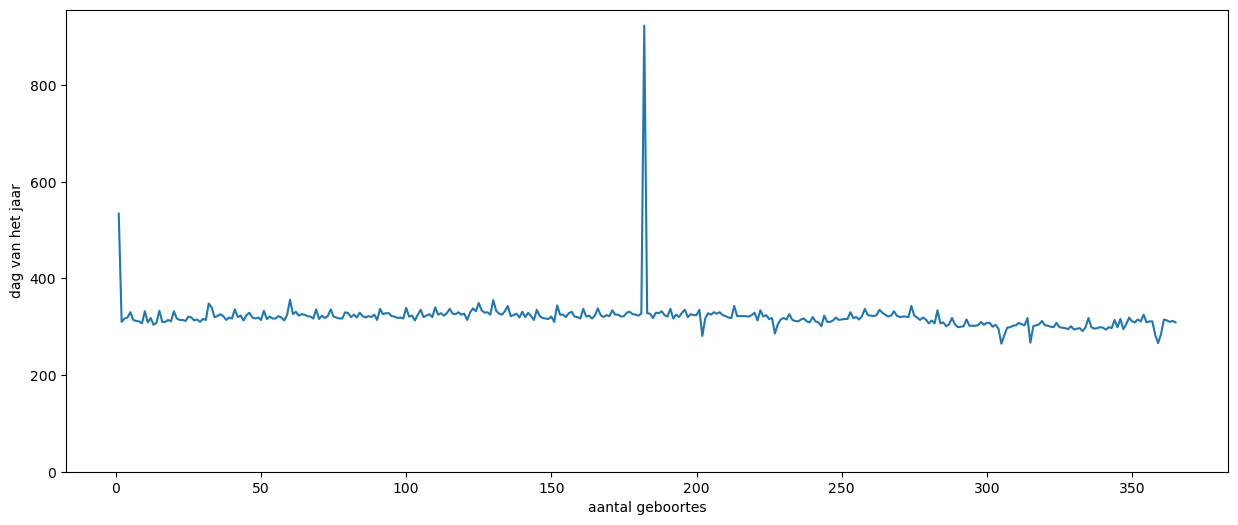

In [662]:
births_per_day = df_birth['dag van het jaar'].value_counts().sort_index(ascending=True)
births_per_day.plot(kind='line', figsize=(15,6), xlabel='aantal geboortes', ylabel='dag van het jaar', ylim=0)

### Vraag 2: Outliers vinden & behandelen

#### We klassificeren een datum als een outlier als het aantal geboortes meer dan 50% afwijkt van de gemiddelde waarde overheen de volledige dataset. Zoek alle outliers in de dataset.

In [663]:
# defining upper and lower bounderies based on mean value
mean_birth = births_per_day.mean()
upper_bound = mean_birth * 1.5
lower_bound = mean_birth * 0.5

births_per_day[((births_per_day > upper_bound) | (births_per_day < lower_bound))]

dag van het jaar
1      534
182    923
Name: count, dtype: int64

In [664]:
# to do: 182 en 1 via variabelen ipv hardcoded
# to do: datetime objecten omzetten in strings
valid_dates_mask = ((df_birth['dag van het jaar'] != 182) & (df_birth['dag van het jaar'] != 1))
df_wrong = pd.concat([df_wrong, df_birth[~valid_dates_mask]
                            .drop(columns={'dag van het jaar'})
                            .rename(columns={'datum': 'reason'})], ignore_index=True)
df_birth = df_birth[valid_dates_mask]

#### Maak dezelfde plot nu opnieuw met het aantal geboortes per dag.

<Axes: xlabel='aantal geboortes', ylabel='dag van het jaar'>

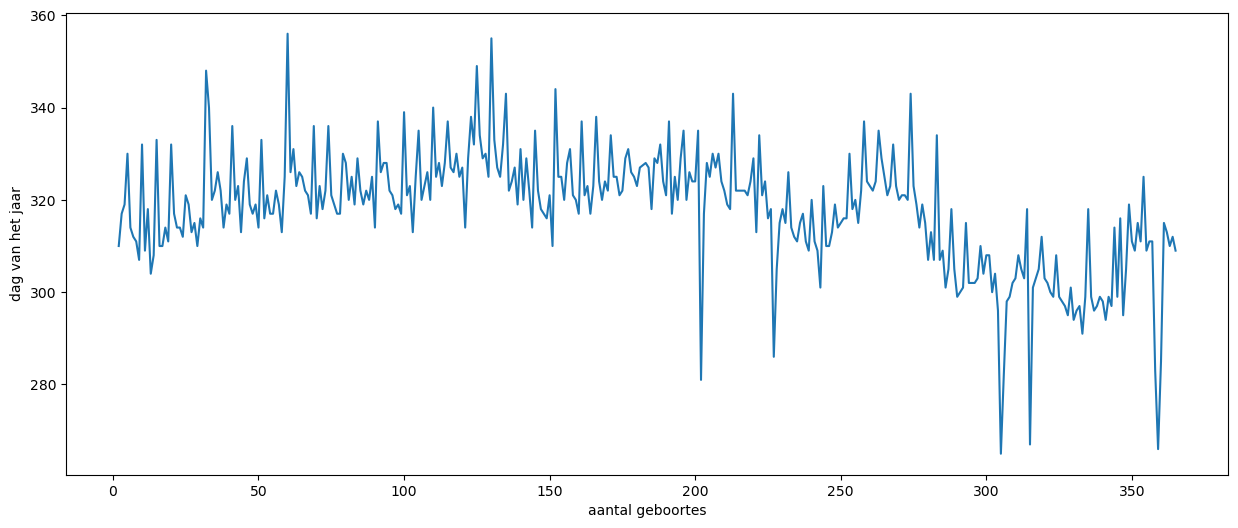

In [665]:
births_per_day = df_birth['dag van het jaar'].value_counts().sort_index(ascending=True)
births_per_day.plot(kind='line', figsize=(15,6), xlabel='aantal geboortes', ylabel='dag van het jaar')

#### We zien dat er nog steeds redelijk wat uitschieters zijn, kan je code schrijven om de 5 extreme uitschieters in de 2e helft van het jaar identificeren (in totaal 8 datums)?

In [666]:
births_per_day = births_per_day.to_frame()

In [667]:
# to do: nakijken wat hiermee scheelt

outliers = detect_outliers_with_rolling_window(births_per_day, window_size=7, threshold=4)
print(outliers[(outliers['count'].notna()) & (outliers.index > 182)])
len(outliers[(outliers['count'].notna()) & (outliers.index > 182)])

                  count
dag van het jaar       
202               281.0
220               329.0
221               313.0
253               330.0
305               265.0
315               267.0
344               314.0
358               283.0


8

In [668]:
print(births_per_day[births_per_day['count']<290])
len(births_per_day[births_per_day['count']<290])

                  count
dag van het jaar       
202                 281
227                 286
305                 265
306                 282
315                 267
358                 283
359                 266
360                 285


8

## Stap 3: Onderzoeksvragen

### Onderzoek 1: Unisex namen

In [669]:
df_names = df_birth_raw.drop(columns=['gemeente', 'verwachte datum', 'datum']).copy()

df_names_women = df_names[df_names.geslacht == 'Vrouwelijk'].groupby('naam').count().rename(columns={'geslacht': 'aantal_vrouw'})
df_names_men = df_names[df_names.geslacht == 'Mannelijk'].groupby('naam').count().rename(columns={'geslacht': 'aantal_man'})

df_names = pd.merge(df_names_women, df_names_men, how='inner', on='naam')
df_names.head()

,aantal_vrouw,aantal_man
naam,,
Adama,3,1
Alexis,1,68
Amel,13,1
Amine,1,32
Andrea,46,22


#### Hoeveel unisex namen zijn er?

In [670]:
len(df_names)

75

#### Wat is de meest voorkomende unisex naam; hiervoor zoek ik 3 namen (en getallen):
- De meest populaire unisex naam bij mannen.
- De meest populaire unisex naam bij vrouwen.
- De meest popuaire unisex naam.

In [671]:
df_names['aantal_totaal'] = df_names['aantal_man'] + df_names['aantal_vrouw']
unisex_name_analysis(df_names)

Populairste unisex naam bij mannen: Maxime
Populairste unisex naam bij vrouwen: Dominique
Populairste unisex naam: Dominique


We zien dat er een vrij groot aantal namen veel meer voorkomen bij mannen dan vrouwen (en omgekeerd).
Dit vinden we eigenlijk geen "echte" unisex namen. We noemen een naam "echt unisex" als de naam niet
meer dan 50% meer voorkomt bij 1 van de 2 geslachten. Dus als er x mannen en y vrouwen zijn genaamd
Chris, dan noemen we Chris "echt unisex" als x <= 1.5 * y en y <= x * 1.5. Filter je unisex dataframe tot
een df_real_unisex waarbij je enkel de "echte" unisex namen weerhoudt.

In [672]:
df_real_unisex = df_names[(df_names['aantal_man'] <= df_names['aantal_vrouw'] * 1.5) & (df_names['aantal_vrouw'] <= df_names['aantal_man'] * 1.5)].copy()
df_real_unisex

,aantal_vrouw,aantal_man,aantal_totaal
naam,,,
Beau,1,1,2
Deniz,5,5,10
Dominique,233,161,394
Dursun,1,1,2
Gabriele,4,6,10
Isa,2,3,5
Joni,4,3,7
Niki,3,2,5
Noa,26,36,62


#### Beantwoord nu bovenstaande 3 vragen opnieuw voor deze dataset. Hierbij werk je best met een functie zodat je geen code moet herhalen!

In [673]:
unisex_name_analysis(df_real_unisex)

Populairste unisex naam bij mannen: Dominique
Populairste unisex naam bij vrouwen: Dominique
Populairste unisex naam: Dominique


#### Zijn de echte unisex namen populairder bij mannen of vrouwen, of is de populariteit hetzelfde? Deze vraag kan je beantwoorden door te kijken naar het percentage mannen/vrouwen met een echte unisex naam.

In [674]:
n_unisex_women = df_real_unisex.aantal_vrouw.sum(axis=0)
n_unisex_men = df_real_unisex.aantal_man.sum(axis=0)
n_total_women = len(df_birth_raw[df_birth_raw.geslacht == 'Vrouwelijk'])
n_total_men = len(df_birth_raw[df_birth_raw.geslacht == 'Mannelijk'])

p_unisex_women = round(n_unisex_women / n_total_women * 100, 1)
p_unisex_men = round(n_unisex_men / n_total_men * 100, 1)

print(f'Percentage vrouwen met unisex naam: {p_unisex_women}%')
print(f'Percentage mannen met unisex naam: {p_unisex_men}%')

Percentage vrouwen met unisex naam: 0.5%
Percentage mannen met unisex naam: 0.4%


In [675]:
df_real_unisex.loc[:, 'p_vrouw'] = df_real_unisex['aantal_vrouw'] / df_real_unisex['aantal_totaal']
df_real_unisex.loc[:, 'p_man'] = df_real_unisex['aantal_man'] / df_real_unisex['aantal_totaal']
df_real_unisex.sort_values('p_man', ascending=True, inplace=True)

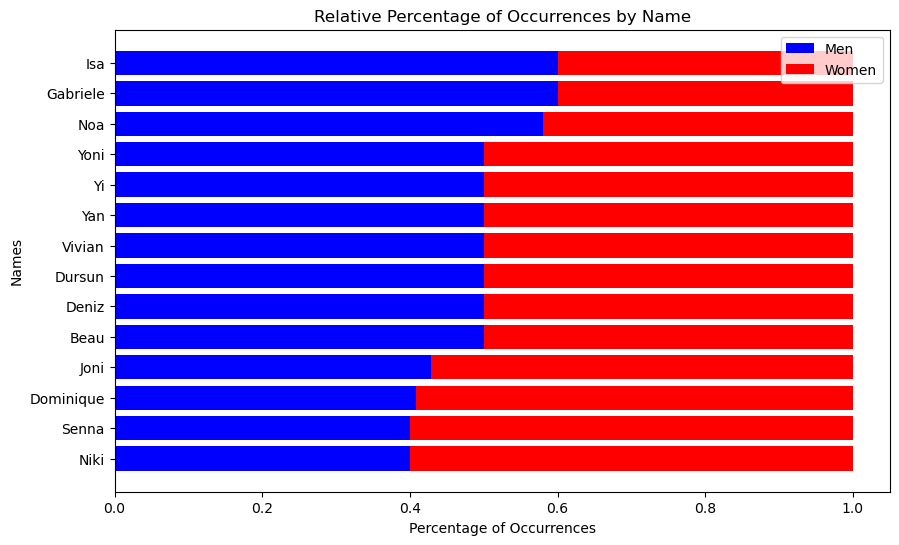

In [676]:
# Plot horizontal bar chart
fig, ax = plt.subplots(figsize=(10, 6))

# Plot men's percentage
ax.barh(df_real_unisex.index, df_real_unisex['p_man'], color='blue', label='Men')

# Plot women's percentage on top of men's
ax.barh(df_real_unisex.index, df_real_unisex['p_vrouw'], left=df_real_unisex['p_man'], color='red', label='Women')

# Add labels and legend
ax.set_xlabel('Percentage of Occurrences')
ax.set_ylabel('Names')
ax.set_title('Relative Percentage of Occurrences by Name')
ax.legend()

# Show plot
plt.show()

### Onderzoek 2: de accuraatheid van de geschatte bevallingsdatum

In [677]:
# transform verwachte datum to datetime object and calculate its dag van het jaar 
df_birth['verwachte datum'] = pd.to_datetime(df_birth['verwachte datum'])
df_birth['dag van het jaar verwacht'] = df_birth['verwachte datum'].dt.dayofyear

# replace values outside of 2019 with NaN
df_birth.loc[df_birth['verwachte datum'].dt.year != 2019, 'dag van het jaar verwacht'] = float('nan')

# estimated births per day
births_per_day_est = df_birth['dag van het jaar verwacht'].value_counts().sort_index(ascending=True)

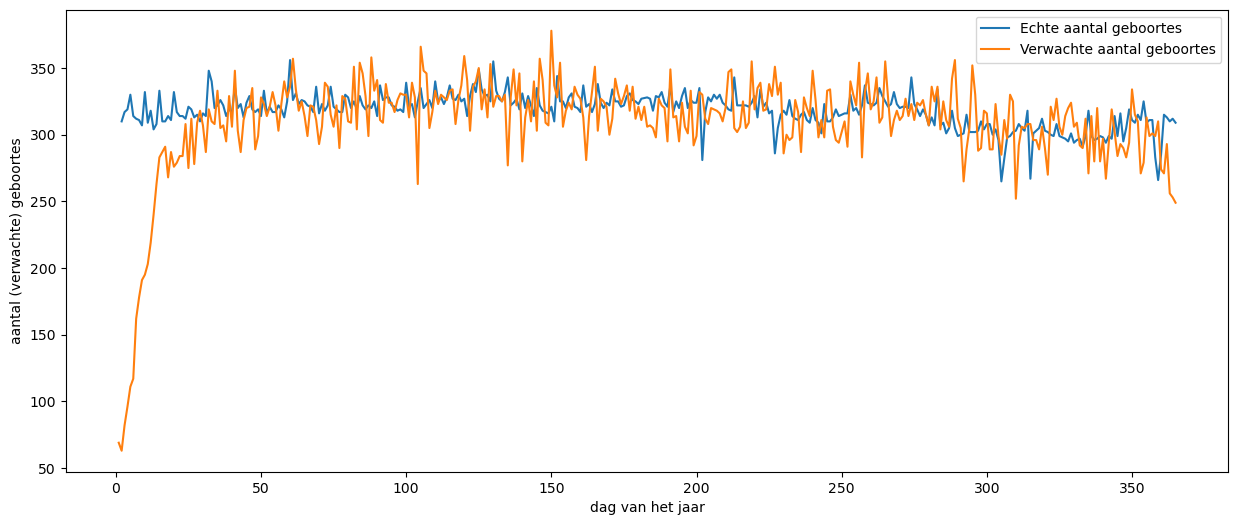

In [678]:
# Create a figure
fig, ax = plt.subplots(figsize=(15, 6))

# Plot the first graph
ax.plot(births_per_day, label='Echte aantal geboortes')

# Plot the second graph
ax.plot(births_per_day_est, label='Verwachte aantal geboortes')

# Add labels and legend
ax.set_xlabel('dag van het jaar')
ax.set_ylabel('aantal (verwachte) geboortes')
ax.legend()

# Display the plot
plt.show()

#### Bonusvraag: Gewoon om over na te denken: waarom zien de uiteindes van je plot er wat gek uit? Schrijf het antwoord neer in een strategisch geplaatste markdown cel.

In [679]:
df_birth[df_birth['verwachte datum'].dt.year != 2019]

,gemeente,naam,geslacht,verwachte datum,datum,dag van het jaar,dag van het jaar verwacht
3683,Namen,Sabrina,Vrouwelijk,2018-12-30,2019-01-02,2,NaN
3704,Overijse,Karel,Mannelijk,2018-12-31,2019-01-02,2,NaN
3724,Maasmechelen,Merel,Vrouwelijk,2018-12-27,2019-01-02,2,NaN
3728,Schoten,Stan,Mannelijk,2018-12-29,2019-01-02,2,NaN
3732,Kasterlee,Robert,Mannelijk,2018-12-29,2019-01-02,2,NaN
...,...,...,...,...,...,...,...
37959,Charleroi,Duygu,Vrouwelijk,2020-01-06,2019-12-09,343,NaN
37973,Zottegem,Marie,Vrouwelijk,2020-01-06,2019-12-09,343,NaN
37977,Dilbeek,Karen,Vrouwelijk,2020-01-04,2019-12-09,343,NaN
37981,Heusden-Zolder,Claudia,Vrouwelijk,2020-01-05,2019-12-09,343,NaN


de reden dat het verwachte aantal geboortes aan de lage kant ligt is omdat deze zoals hierboven te zien buiten 2019 kan vallen en dus niet in rekening wordt gebracht